#### Paquetes necesarios

In [1]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output 
import re

#### Método para mostrar imágenes con matplotlib

In [2]:
# Método que coloca dos imágenes en una misma figura
def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)
    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)
    plt.show()

#### Método para corregir formato de la matrícula (matrícula española)

In [3]:
def plate_validation(plate):
    # Definir el patrón de la matrícula "0000 AAA"
    plate_pattern = re.compile(r'^\d{4}\s[A-Z]{3}$')

    if plate_pattern.match(plate):
        # La matrícula cumple con el formato
        return plate
    else:
        # La matrícula no cumple con el formato, intentar corregirla
        plate_refactored = re.sub(r'^\s*.*?(\d{4}\s[A-Z]{3}).*$', r'\1', plate)
        return plate_refactored

#### Detección de matrículas básica (zonas rectangulares)

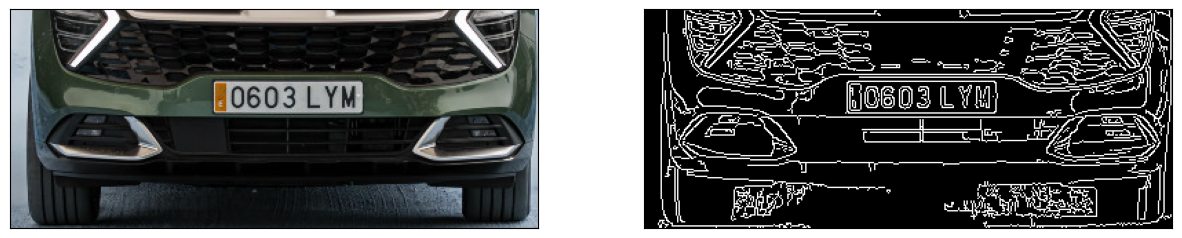

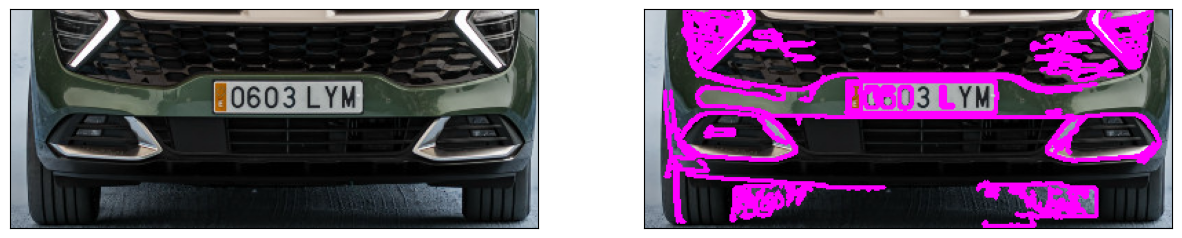

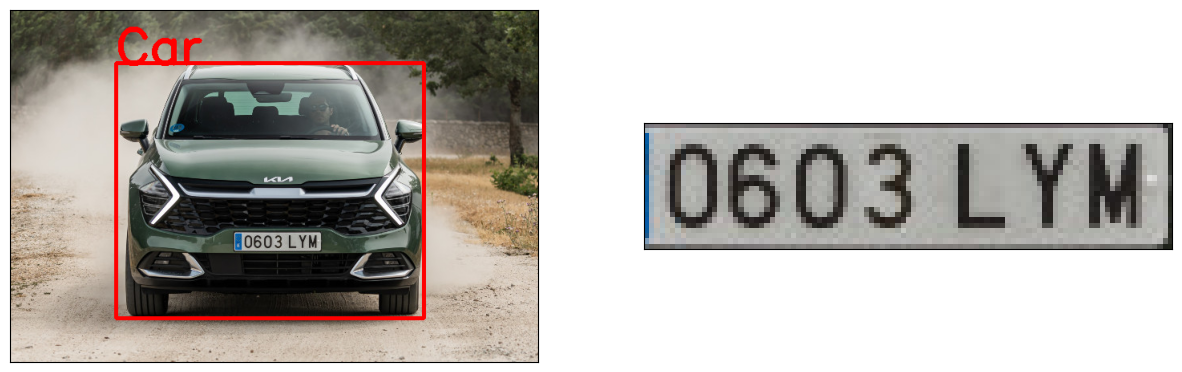


[+] MATRÍCULA DETECTADA: 0603 LYM



In [4]:
# Cargamos el modelo de YOLO
model_car = YOLO('Models/yolov8n.pt')

# Guardamos la ruta absoluta de tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

def plate_detector(image, show_plot=True):
    # Guardamos imagen en variable
    car = cv2.imread("Images/" + image)

    # Detectar coches
    results_cars = model_car(car, verbose=False)

    # Para cada detección de coche
    for r_car in results_cars:
        boxes_car = r_car.boxes

        for box_car in boxes_car:
            # Si la clase es un coche
            if int(box_car.cls[0]) == 2:
                # Coordenadas del cuadro del coche
                x1_car, y1_car, x2_car, y2_car = box_car.xyxy[0]

                # Definir la región inferior para buscar matrículas
                roi_bottom = car[int((y1_car + y2_car) / 2):int(y2_car), int(x1_car):int(x2_car)]

                # Convertir la región a escala de grises
                gray_roi_bottom = cv2.cvtColor(roi_bottom, cv2.COLOR_BGR2GRAY)

                # Obtener bordes con canny
                edges = cv2.Canny(gray_roi_bottom, 30, 200)
                
                if show_plot:
                    plot_images(roi_bottom, edges)

                # Obtener contornos
                cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

                # Obtener los 30 primeros contornos con mayor área
                cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]

                image_copy = roi_bottom.copy()

                # Dibujar los contornos en la imagen
                _ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)

                if show_plot:
                    plot_images(roi_bottom, image_copy)

                plate = None
                for c in cnts:
                    # Obtener el perímetro y el número de bordes
                    perimeter = cv2.arcLength(c, True)
                    edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
                    # Si el contorno tiene 4 vértices, es una matrícula
                    if len(edges_count) == 4:
                        x,y,w,h = cv2.boundingRect(c)
                        # Ajustamos las coordenadas de la matricula al tamaño original de la imagen
                        x, y, w, h = int(x + x1_car), int(y + (y1_car + y2_car) / 2), int(w), int(h)
                        plate = car[y:y+h, x+10:x+w]
                        break

                # Dibuja el contenedor y clase
                cv2.rectangle(car, (int(x1_car), int(y1_car)), (int(x2_car), int(y2_car)), (0, 0, 255), 4)
                cv2.putText(car, "Car" , [int(x1_car), int(y1_car)], cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 5)

                # Si se ha detectado una matrícula se muestra en RGB
                car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
                plate = cv2.cvtColor(plate, cv2.COLOR_BGR2RGB)
                
                if plate is not None:
                    plot_images(car, plate)

                text = pytesseract.image_to_string(plate, config='--psm 8', output_type=Output.STRING)

                text = plate_validation(text)

                print("\n[+] MATRÍCULA DETECTADA:", text)

plate_detector("coche1.jpg")

#### Test con coches diferentes

----------------------------------------------------- COCHE 1 -----------------------------------------------------


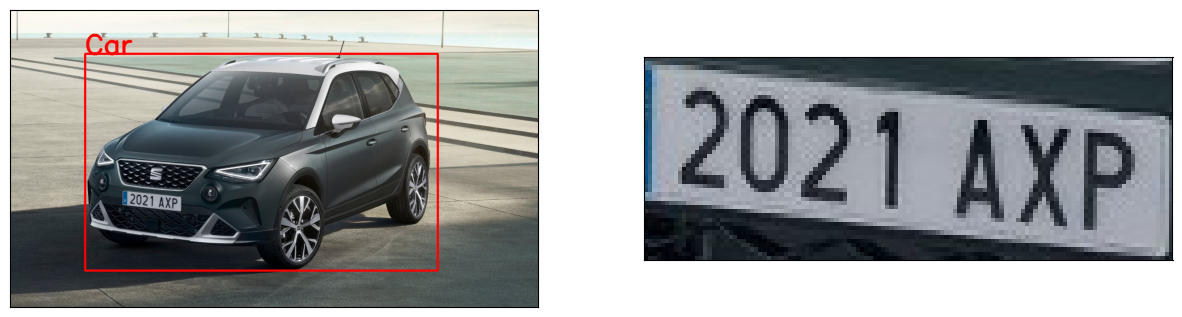


[+] MATRÍCULA DETECTADA: 2021 AXP

----------------------------------------------------- COCHE 2 -----------------------------------------------------


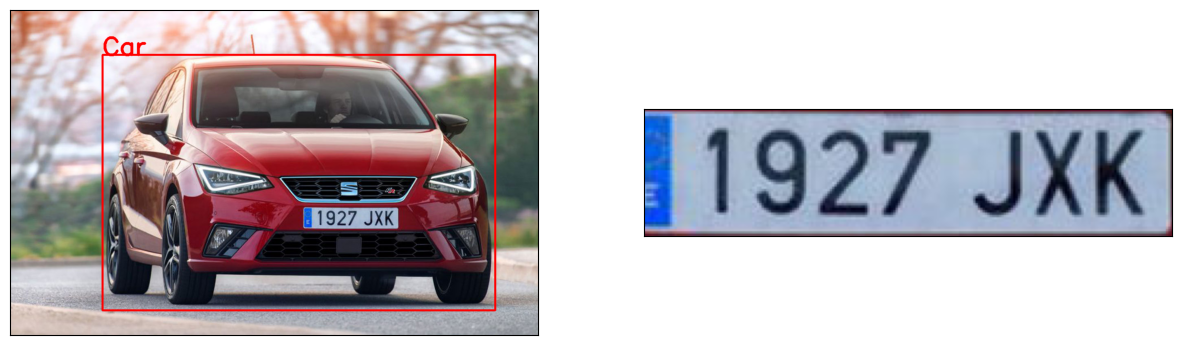


[+] MATRÍCULA DETECTADA: 1927 JXK

----------------------------------------------------- COCHE 3 -----------------------------------------------------


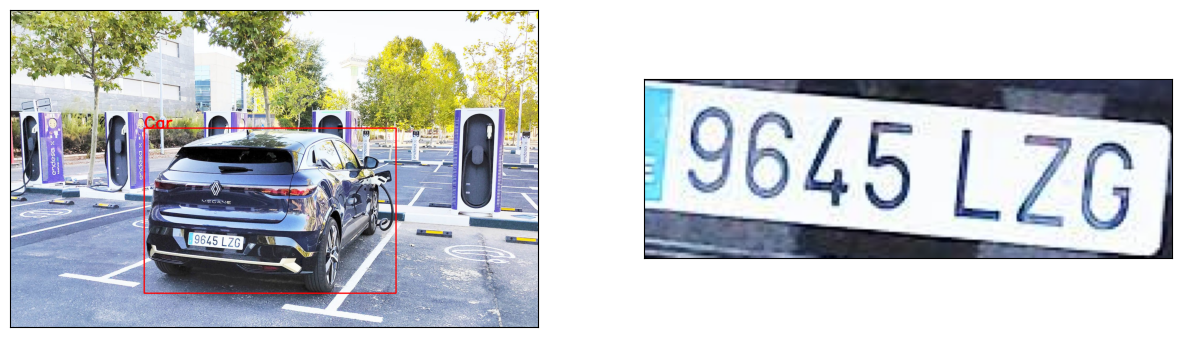


[+] MATRÍCULA DETECTADA: 9645 LZG

----------------------------------------------------- COCHE 4 -----------------------------------------------------


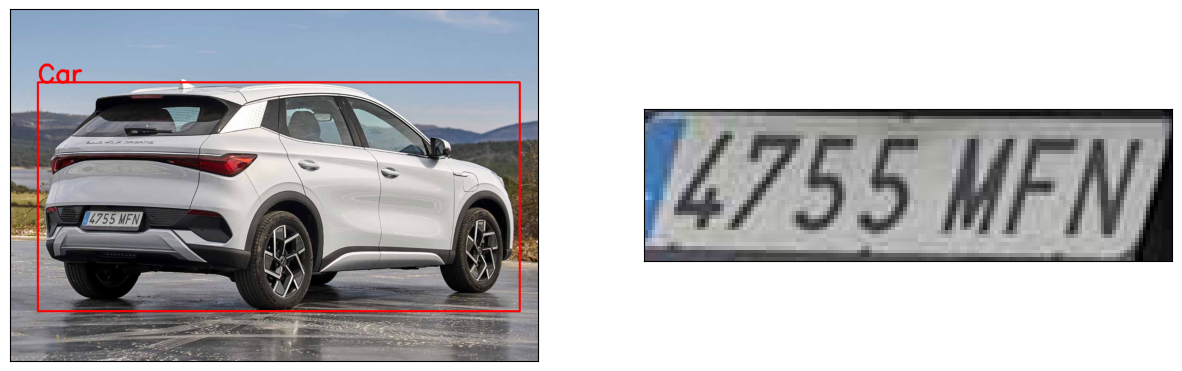


[+] MATRÍCULA DETECTADA: 4755 MFN



In [5]:
print("----------------------------------------------------- COCHE 1 -----------------------------------------------------")
plate_detector(image="coche2.jpeg", show_plot=False)

print("----------------------------------------------------- COCHE 2 -----------------------------------------------------")
plate_detector(image="coche3.jpg", show_plot=False)

print("----------------------------------------------------- COCHE 3 -----------------------------------------------------")
plate_detector(image="coche4.jpeg", show_plot=False)

print("----------------------------------------------------- COCHE 4 -----------------------------------------------------")
plate_detector(image="coche5.jpg", show_plot=False)